In [35]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

sys.path.append("./dataset")
# 数据集类
from mnist import MnistDataset
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(3)

# 鉴别器
## 改进一：使用二元交叉熵BCELoss()
## 改进二：使用泄露的线性整流激活函数LeakyReLU()
## 改进三：使用层归一化方法
## 改进四：使用Adam优化器

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                        nn.Linear(28*28, 200),
                        # nn.Sigmoid(),
                        nn.LeakyReLU(0.02),

                        nn.LayerNorm(200),

                        nn.Linear(200, 1),
                        nn.Sigmoid()
        ).type(dtype)

        # 创建损失函数
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()

        # 创建优化器, 使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), 
        #                                     lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), 
                                            lr=0.0001)

        # 计数器和进程记录
        self.counter = 0
        self.progress = []
                
    def forward(self,inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.model(inputs)
        
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        
        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        # if (self.counter % 10000 == 0): print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1

        pass
    
    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Discriminator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()
        pass

# 生成器
## 改进五：增加生成器随机输入的数量
## 改进六：将生成器的随机输入改进位标准高斯分布
## 改进七：加多训练的世代数

In [37]:
class Generator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                    nn.Linear(100, 200),
                    # nn.Sigmoid(),
                    nn.LeakyReLU(0.02),

                    nn.LayerNorm(200),
                        
                    nn.Linear(200, 28*28),
                    nn.Sigmoid()
        ).type(dtype)

        # 创建优化器，使用随机梯度下降
        # self.optimiser = torch.optim.SGD(self.parameters(), 
        #                                     lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), 
                                            lr=0.0001)
        
        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入鉴别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)

        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        if (self.counter % 30000 == 0): print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
    
    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Generator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()
        pass

    def plot_image(self, inputs):
        # 计算网络输出
        g_output = self.forward(inputs)
        g_output = np.array(g_output.detach().cpu()).reshape(28,28)
        figure, ax = plt.subplots()
        im = ax.imshow(g_output)
        plt.colorbar(im)
        plt.title('image of Generator')
        plt.show()

    def plot_image6(self, inputs):
        figure, ax = plt.subplots(2,3,figsize=(16,8))
        for i in range(2):
            for j in range(3):
                g_output = self.forward(inputs())
                g_output = np.array(g_output.detach().cpu()).reshape(28,28)
                ax[i,j].imshow(g_output,interpolation='none',cmap='Blues')

# 训练网络

In [38]:
# 创建生成器和鉴别器
D = Discriminator()
G = Generator()

# 测试生成器

In [39]:
def generate_random(size=1):
    random_data = torch.rand(size).type(dtype)
    return random_data
def generate_random_norm(size=100):
    random_data = torch.randn(size).type(dtype)
    return random_data

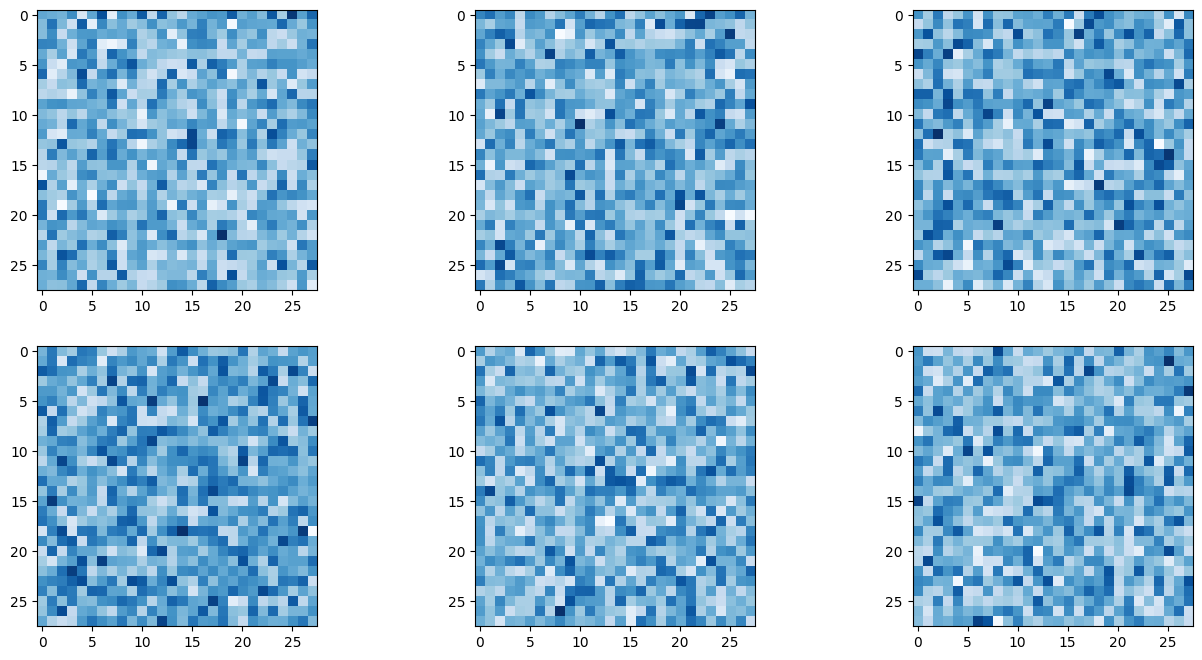

In [40]:
G.plot_image6(generate_random_norm)

# 导入数据集

In [41]:
path = r"./dataset"

filename_images = "train-images-idx3-ubyte"
filename_labels = "train-labels-idx1-ubyte"
filename_images = path+"/"+filename_images
filename_labels = path+"/"+filename_labels


Mnist_train = MnistDataset(filename_images, filename_labels)

dataset_images is existing
dataset_labels is existing


In [42]:
epochs = 10
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for label, image_values, target in Mnist_train:
        # 正确值
        D.train(image_values.type(dtype), torch.FloatTensor([1.0]).type(dtype))
        # 用生成器生成的数据训练鉴别器（错误 0.0）
        D.train(G.forward(generate_random_norm()).detach(), torch.FloatTensor([0.0]).type(dtype))
        # 用生成器生成的数据训练生成器(正确 1.0）
        G.train(D, generate_random_norm(), torch.FloatTensor([1.0]).type(dtype))

epoch =  1
counter =  0
counter =  30000
epoch =  2
counter =  60000
counter =  90000
epoch =  3
counter =  120000
counter =  150000
epoch =  4
counter =  180000
counter =  210000
epoch =  5
counter =  240000
counter =  270000
epoch =  6
counter =  300000
counter =  330000
epoch =  7
counter =  360000
counter =  390000
epoch =  8
counter =  420000
counter =  450000
epoch =  9
counter =  480000
counter =  510000
epoch =  10
counter =  540000
counter =  570000


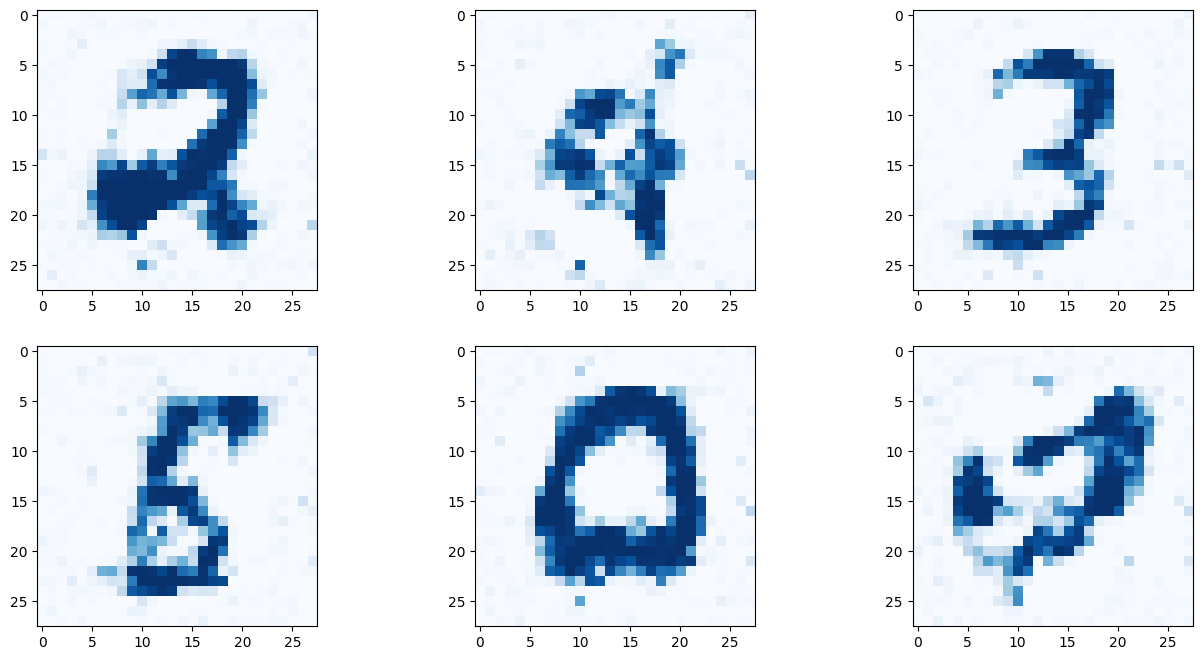

In [63]:
G.plot_image6(generate_random_norm)

# 优化
1、损失函数     
2、激活函数     
3、优化器       
4、网络结构     
5、输入数据的预处理

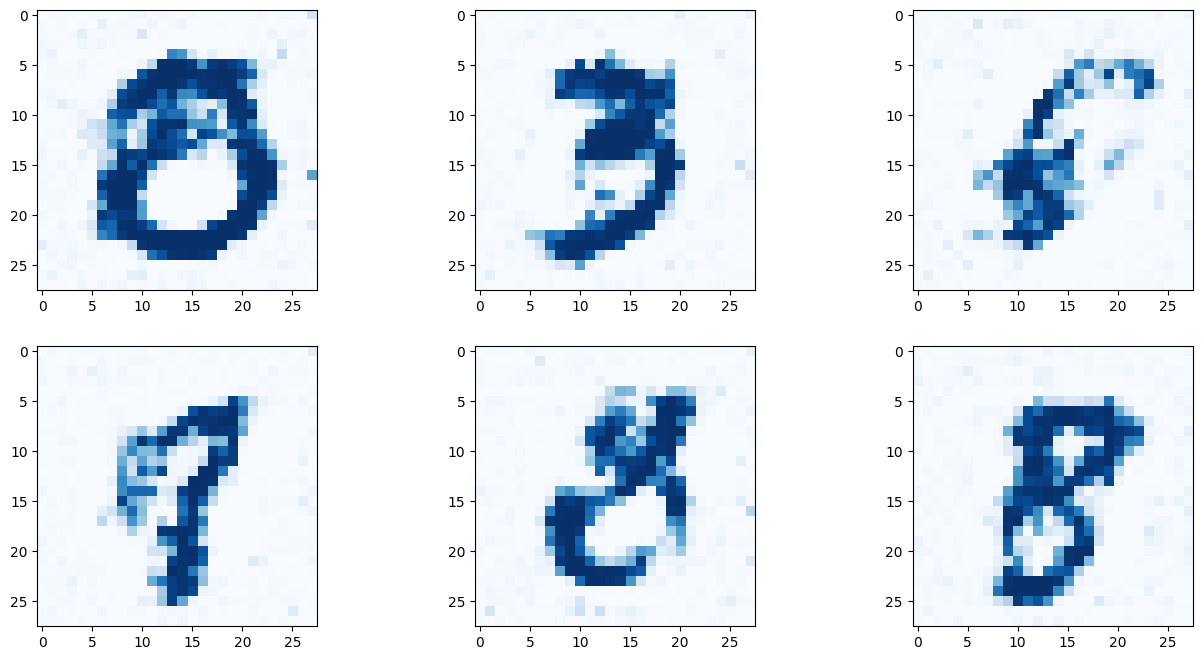

In [77]:
figure, ax = plt.subplots(2,3,figsize=(16,8))
for i in range(2):
    for j in range(3):
        g_output = G.forward(generate_random_norm())
        g_output = np.array(g_output.detach().cpu()).reshape(28,28)
        ax[i,j].imshow(g_output,interpolation='none',cmap='Blues')